# To do:
- Cross validation (Done)
- Leave out some feature and see what happens, may apply to other datasets (DES?)
- Customized matrix?

# Hack or Hammer: Can Neural Networks Classify Stellar Types?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Feedfoward Neural Networks
from keras.models import Sequential #the model is built adding layers one after the other
from keras.layers import Dense #fully connected layers: every output talks to every input
from keras.layers import Dropout #for regularization
from keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from keras import layers

2025-04-15 15:43:48.950928: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 15:43:48.983951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%run final_project_functions.ipynb

## Introduction
- What is spectral classes?
- Attach example spectra
- Saha's equation + Boltzman's equation

In [3]:
df = pd.read_csv('SDSS.csv', header = 1)
df.dtypes

specObjID          uint64
sourceType         object
ra                float64
dec               float64
class              object
subclass           object
class_noqso        object
subClass_noqso     object
u                 float64
g                 float64
r                 float64
i                 float64
z1                float64
err_u             float64
err_g             float64
err_r             float64
err_i             float64
err_z             float64
dered_u           float64
dered_g           float64
dered_r           float64
dered_i           float64
dered_z           float64
elodieSpType       object
elodieBV          float64
elodieTEff          int64
elodieLogG        float64
elodieFeH         float64
dtype: object

## Data exploration
This is not a easy problem! <br>
Why?: A easy temperature and color cut is not enough to seperate spectral classes. In reality, we have to measure the spectra and identify absorption feature through the stellar atmosphere. 

number of rows after filtering: 74123


/tmp/ipykernel_29980/2815517422.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_temps, labels=class_labels, patch_artist=True,


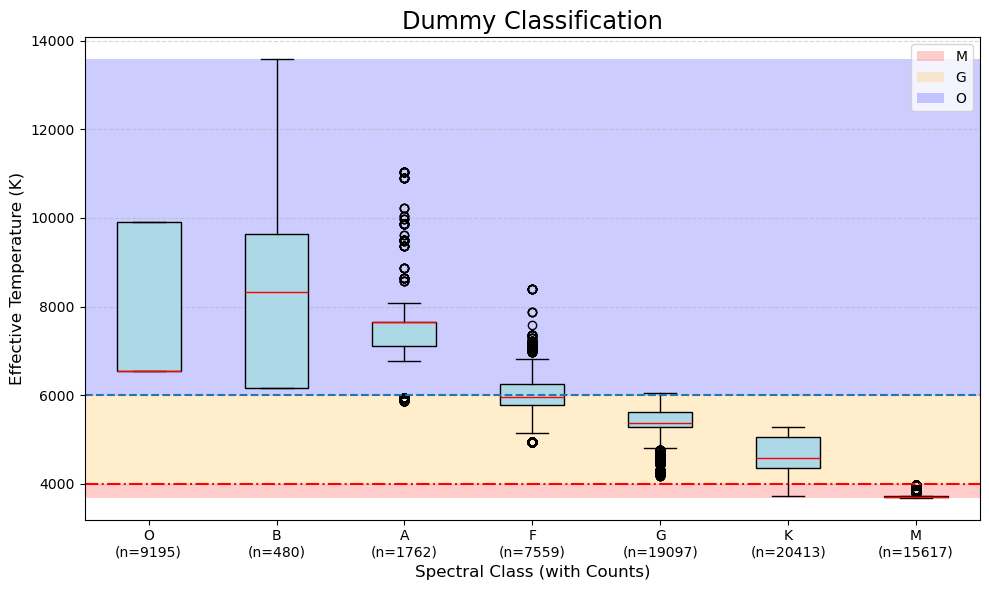

In [4]:
# Extract first letter of spectral type
df['SpClass'] = df['elodieSpType'].str[0]

# Filter to valid spectral types and remove NaNs
valid_classes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
df = df[df['SpClass'].isin(valid_classes)].dropna(subset=['elodieTEff'])
print(f'number of rows after filtering: {df.shape[0]}')

# Group TEff values and count per class
grouped_temps = []
class_labels = []

for cls in valid_classes:
    class_data = df[df['SpClass'] == cls]['elodieTEff'].values
    grouped_temps.append(class_data)
    class_labels.append(f"{cls}\n(n={len(class_data)})")  # Add count in label

plt.figure(figsize=(10, 6))
plt.boxplot(grouped_temps, labels=class_labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

plt.axhline(4000, linestyle = '-.', c = 'red')
plt.axhline(6000, linestyle = '--')
plt.axhspan(min(df['elodieTEff']), 4000, facecolor='red', alpha=0.2, label='M')
plt.axhspan(4000, 6000, facecolor='orange', alpha=0.2, label='G')
plt.axhspan(6000, max(df['elodieTEff']), facecolor='blue', alpha=0.2, label='O')

plt.xlabel('Spectral Class (with Counts)', fontsize = 'large')
plt.ylabel('Effective Temperature (K)', fontsize = 'large')
plt.title('Dummy Classification', fontsize = 'xx-large')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

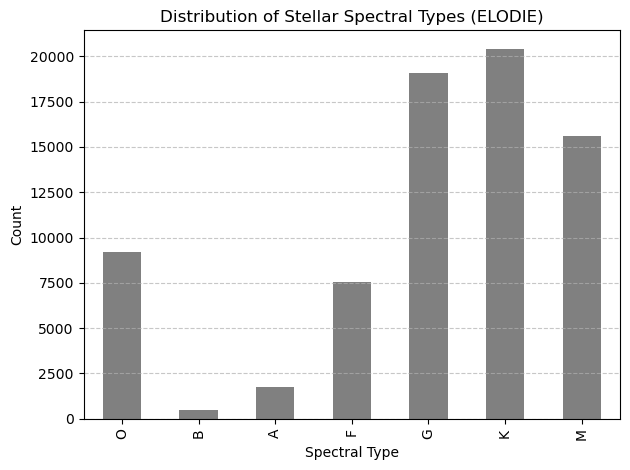

In [5]:
# Extract first letter and count frequencies
spectral_counts = df['elodieSpType'].str[0].value_counts()

# Desired spectral order
ordered_labels = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Reindex to match OBAFGKM (missing types will be filled with NaN and skipped by default)
spectral_counts = spectral_counts.reindex(ordered_labels).fillna(0)

# Define colors: highlight O, G, M in blue, rest in grey
colors = ['grey' for sp in spectral_counts.index]
# colors = ['blue' if sp in ['O', 'G', 'M'] else 'grey' for sp in spectral_counts.index]

# Bar plot with custom order and colors
spectral_counts.plot(kind='bar', color=colors)
plt.xlabel('Spectral Type')
plt.ylabel('Count')
plt.title('Distribution of Stellar Spectral Types (ELODIE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Effective Temperature (K)')

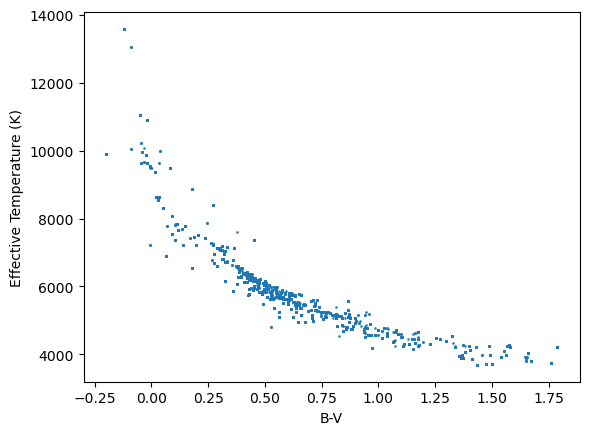

In [6]:
plt.scatter(df['elodieBV'], df['elodieTEff'], s = 1, alpha = 0.8)
plt.xlabel('B-V')
plt.ylabel('Effective Temperature (K)')

## Approach
- What is neural network?
- How it can be useful and not useful?
- What is CV?
- Explain why this model choice is suitable for the dataset
- Strength and weakness of this method

## Initial Results
### Benchmark model


In [7]:
df['dummySpClass'] = df['elodieTEff'].apply(
    lambda T: 'M' if T < 4000 else ('G' if T <= 6000 else 'O')
)
np.mean(df['dummySpClass'] == df['SpClass'])

0.5921643754300284

In [8]:
# Select only the numeric columns from the SDSS DataFrame
numeric_col = df.select_dtypes(include='number').columns.tolist()
numeric_col = [col for col in numeric_col if col not in ['specObjID', 'err_u', 'err_g', 'err_r', 'err_i', 'err_z']]
X = df[numeric_col]
y = df['SpClass']
print(X.columns)

Index(['ra', 'dec', 'u', 'g', 'r', 'i', 'z1', 'dered_u', 'dered_g', 'dered_r',
       'dered_i', 'dered_z', 'elodieBV', 'elodieTEff', 'elodieLogG',
       'elodieFeH'],
      dtype='object')


#### Data Splitting

- One hot encoding demo
| Spectral Class | One-Hot Encoding           |
|----------------|----------------------------|
| O              | [1, 0, 0, 0, 0, 0, 0]       |
| G              | [0, 0, 0, 0, 1, 0, 0]       |
| M              | [0, 0, 0, 0, 0, 0, 1]       |


In [9]:
# Shuffle the data and target labels while preserving the correspondence
X,y = shuffle(X,y, random_state = 406)
# slight modification to the catergorical output
# Your custom mapping (example: skip every other integer)
le = LabelEncoder()
y_encoded = le.fit_transform(y)          # Converts to integers: [0, 1, 2, ...]
y_categorical = to_categorical(y_encoded)  # One-hot encode

# --- Manually splitting our dataset
# Use 70/20/10 split here
split1 = int(0.7*len(X))
split2 = int(0.9*len(X))
# First 70% samples will be the training set
X_train = X.values[:split1,:]
y_train = y_categorical[:split1]
# Next 20% samples will be the validation set, used to minimize loss function
X_val = X.values[split1:split2,:]
y_val = y_categorical[split1:split2]
# Last 10% samples will be the test set, used to test the model performance
X_test = X.values[split2:,:]
y_test = y_categorical[split2:]

# use StandardScaler() to scale the dataset
scaler = StandardScaler()
scaler.fit(X_train)

Xst_train = scaler.transform(X_train)
Xst_val = scaler.transform(X_val)
Xst_test = scaler.transform(X_test)

# Confirm the shapes of the datasets
print(X_train.shape, X_val.shape, X_test.shape)

(51886, 16) (14824, 16) (7413, 16)


#### The number of parameters
<span style="color:red">calculate the number of parameters and compare with size of dataset</span>.

In [10]:
# Set up the NN model with the 3 layers
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(Xst_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))

# set up and assign the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# compile the model
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics =['accuracy'])
model.summary() #print summary of the best model
mynet = model.fit(Xst_train, y_train, validation_data= (Xst_val, y_val), epochs = 50, batch_size=200)

/home/yanbopan/anaconda3/envs/astro-416/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,047 (4.09 KB)

 Trainable params: 1,047 (4.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6465 - loss: 0.9277 - val_accuracy: 0.9457 - val_loss: 0.1920
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9079 - loss: 0.2993 - val_accuracy: 0.9526 - val_loss: 0.1358
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9271 - loss: 0.2254 - val_accuracy: 0.9452 - val_loss: 0.1363
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9355 - loss: 0.2244 - val_accuracy: 0.9541 - val_loss: 0.1204
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9363 - loss: 0.2375 - val_accuracy: 0.9568 - val_loss: 0.1201
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9379 - loss: 0.1857 - val_accuracy: 0.9595 - val_loss: 0.1200
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9408 - loss: 0.1802 - val_accuracy: 0.9407 - val_loss: 0.1479
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9389 - loss: 0.1818 - val_accuracy: 0.

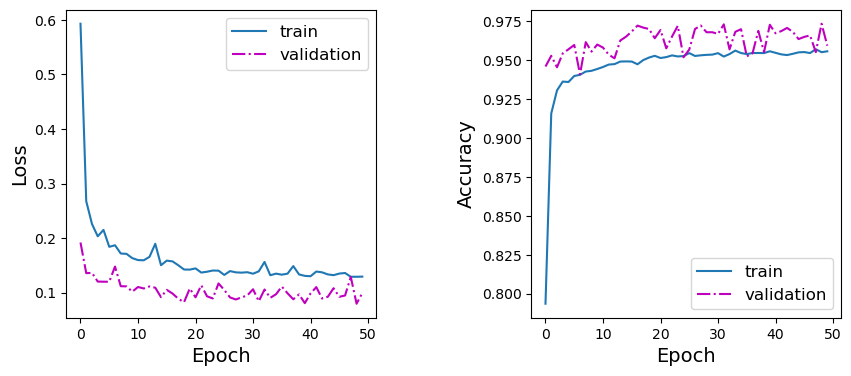

In [11]:
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)

plt.plot(mynet.history['loss'], label = 'train')
plt.plot(mynet.history['val_loss'], '-.m', label = 'validation')
# plt.yscale('log')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(loc='upper right', fontsize = 12)

plt.subplot(122)

plt.plot(mynet.history['accuracy'], label = 'train')
plt.plot(mynet.history['val_accuracy'], '-.m', label = 'validation')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(fontsize = 12)
plt.subplots_adjust(wspace=0.5)

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


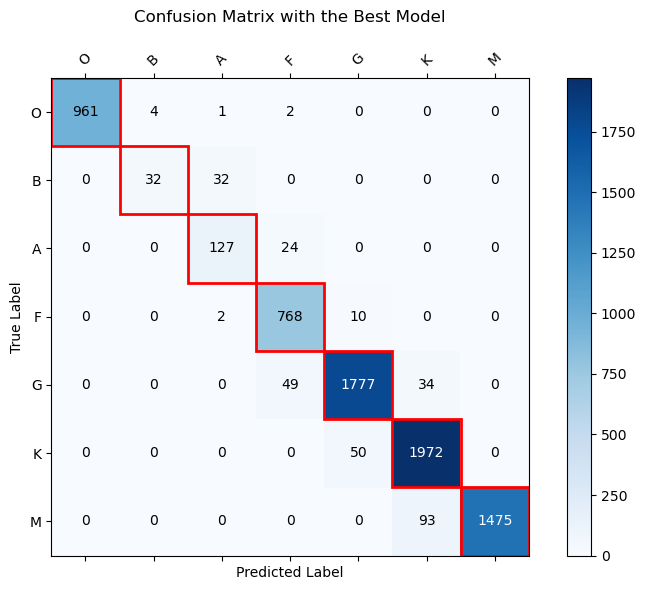

In [12]:
ordered_labels = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
plot_confusion_matrix(model, Xst_test, y_test, le, ordered_labels, title='Confusion Matrix with the Best Model')

<span style="color:red">Create customized metrics here</span>.
#### I will be sad if a O star is being labelled as M

### Hyperparameter tuning

In [13]:
# Fill in the code from the textbook
##### Add more hyperparameter tuning
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(layers.Dense(units = hp.Int('units_' + str(i),
        min_value = 16, max_value = 64, step = 16), activation = 'relu'))
    model.add(Dense(y_train.shape[1], activation = 'softmax'))
    model.compile(optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss = 'mse')
    return model

In [14]:
tf.keras.backend.clear_session() # clear the session to avoid clutter from old models

# Set up the tuner variable (see book) and provide comments to describe what is happening
tuner = RandomSearch(build_model, objective='val_loss', max_trials = 3, executions_per_trial = 3, project_name = 'SpectralClass')
# build_model: provide a series of model (parameters) to tune/choose
# objective: specifies the direction of the optimization and what loss function to use on which dataset. 
# max_trials: the totoal number of trials to test at most for the random search
# executions_per_trial: since the model performance is dependent on the the intial condition, therefore, it is good to run models several times
#                        here, we run each model 3 times to average the randomness
# project_name: name of the directory where tuning results will be saved

tuner.search_space_summary()

Reloading Tuner from ./SpectralClass/tuner0.json
Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}


In [15]:
### takes a long time to run ###
tuner.search(Xst_train, y_train, epochs = 20, validation_data = (Xst_val, y_val), batch_size = 300, verbose = 0)

In [16]:
tuner.results_summary(2)

Results summary
Results in ./SpectralClass
Showing 2 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
num_layers: 2
units_0: 32
units_1: 64
learning_rate: 0.01
units_2: 16
units_3: 16
Score: 0.008086962004502615

Trial 0 summary
Hyperparameters:
num_layers: 2
units_0: 32
units_1: 32
learning_rate: 0.0001
Traceback (most recent call last):
  File "/home/yanbopan/anaconda3/envs/astro-416/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/yanbopan/anaconda3/envs/astro-416/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 265, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/home/yanbopan/anaconda3/envs/astro-416/lib/python3.11/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem

In [17]:
best_hps = tuner.get_best_hyperparameters()[0] #choose first model

print('Best learning rate:', best_hps.get('learning_rate'))
print('Best number of layers:', best_hps.get('num_layers'))

print('Best units in layer 0:', best_hps.get('units_0'))
print('Best units in layer 1:', best_hps.get('units_1'))

Best learning rate: 0.01
Best number of layers: 2
Best units in layer 0: 32
Best units in layer 1: 64


In [18]:
bestmodel = tuner.hypermodel.build(best_hps) #define model = best model
bestmodel.build(input_shape=(None,Xst_train.shape[1])) #build best model (if not fit yet, this will give access to summary)
bestmodel.summary() #print summary of the best model

bestnet = bestmodel.fit(Xst_train, y_train, validation_data= (Xst_val, y_val), epochs=20, batch_size=300)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,111 (12.15 KB)

 Trainable params: 3,111 (12.15 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0451 - val_loss: 0.0166
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - val_loss: 0.0129
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - val_loss: 0.0120
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.0102
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - val_loss: 0.0160
Epoch 9/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0098
Epoch 10/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - val_loss: 0.0094
Epoch 11/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 12/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

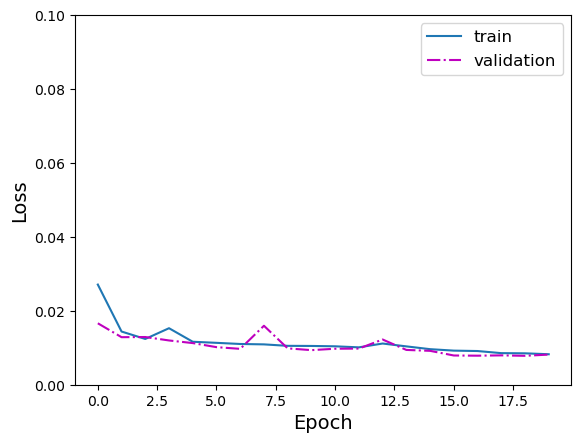

In [19]:
plt.plot(bestnet.history['loss'], label = 'train')
plt.plot(bestnet.history['val_loss'],'-.m', label = 'validation')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.ylim(0,0.1)
plt.legend(loc='upper right', fontsize = 12)
plt.legend(fontsize = 12)

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step


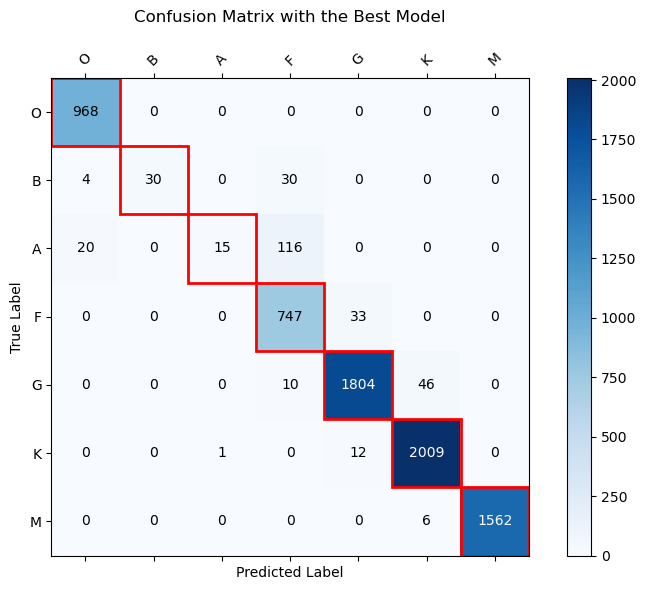

In [20]:
ordered_labels = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
plot_confusion_matrix(bestmodel, Xst_test, y_test, le, ordered_labels, title='Confusion Matrix with the Best Model')

### Let's Cross Validate

#### There are many metrics we can use
How many predictions (both positive and negative) were correct overall
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

How many of the predicted positives are correct
$$\text{Precision} = \frac{TP}{TP + FP}$$

How many of the actual positives were correctly predicted
$$\text{Recall} = \frac{TP}{TP + FN}$$


F1 accounts for both percision and recall
$$\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [21]:
# CV Setup
k = 20
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=416)

# Store metrics
accs, precs, recalls, f1s = [], [], [], []

# Loop over folds
_ = to_categorical(le.fit_transform(y))
for train_index, val_index in skf.split(X, y):
    Xtrain, Xval = X.iloc[train_index], X.iloc[val_index]
    ytrain, yval = y_categorical[train_index], y_categorical[val_index]

    # scale X data inside CV, remember to use the scaled version of data
    scaler = StandardScaler()
    scaler.fit(Xtrain)
    Xst_train = scaler.transform(Xtrain)
    Xst_val = scaler.transform(Xval)
    
    # Build and train model
    model = tuner.hypermodel.build(best_hps)
    model.build(input_shape=(None,Xst_train.shape[1]))
    model.fit(Xst_train, ytrain, epochs=20, batch_size=300, verbose=0)

    # Predict
    yval_pred_probs = model.predict(Xst_val)
    yval_pred = yval_pred_probs.argmax(axis=1)
    yval_true = yval.argmax(axis=1)

    # Compute metrics
    accs.append(accuracy_score(yval_true, yval_pred))
    precs.append(precision_score(yval_true, yval_pred, average='weighted', zero_division=0))
    recalls.append(recall_score(yval_true, yval_pred, average='weighted'))
    f1s.append(f1_score(yval_true, yval_pred, average='weighted'))

# Report results with error bars
print(f'Accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}')
print(f'Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}')
print(f'Recall: {np.mean(recalls):.3f} ± {np.std(recalls):.3f}')
print(f'F1-score: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}')

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy: 0.969 ± 0.009
Precision: 0.954 ± 0.018
Recall: 0.969 ± 0.009
F1-score: 0.959 ± 0.014


## Final Results (Pending)

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


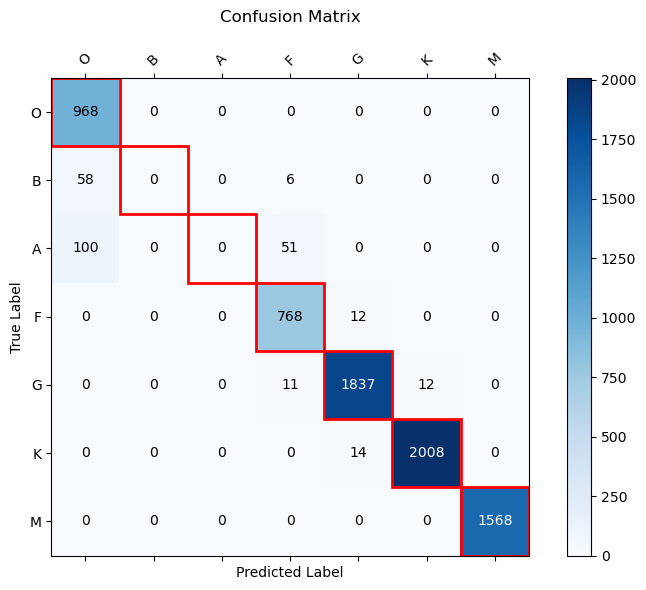

In [22]:
ordered_labels = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
plot_confusion_matrix(model, Xst_test, y_test, le, ordered_labels)

## Reflection

## AI Statement